In [1]:
import matplotlib.pyplot as plt
import numpy as np

import optical_gating_analysis as OG
from tqdm import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend("pgf", FigureCanvasPgf)
matplotlib.rcParams.update(
    {
        # Adjust to your LaTex-Engine
        "pgf.texsystem": "xelatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "axes.unicode_minus": False,
    }
)

matplotlib.rcParams['figure.figsize'] = (4.01407, 3.09654)

In [13]:
oog = OG.BasicOpticalGating()
oog.sequence_manager.set_source(r"E:\data\my data\Arrhythmic imaging April 2024 2\very_good_sync_proprananol\Allied Vision Technologies GS650 0001f61c\*tif")
oog.sequence_manager.set_reference_sequence(r"E:\data\my data\Arrhythmic imaging April 2024 2\very_good_sync_proprananol\ref-frames-2024-04-25-12.34.41\*tif")
oog.sequence_manager.reference_period = 110.514686
#oog.settings["include_reference_frames"] = False
oog.run()

Setting source to E:\data\my data\Arrhythmic imaging April 2024 2\very_good_sync_proprananol\Allied Vision Technologies GS650 0001f61c\*tif
Loading reference sequence from E:\data\my data\Arrhythmic imaging April 2024 2\very_good_sync_proprananol\ref-frames-2024-04-25-12.34.41\*tif


Getting phases: 100%|██████████| 6541/6541 [00:00<00:00, 160577.24it/s]


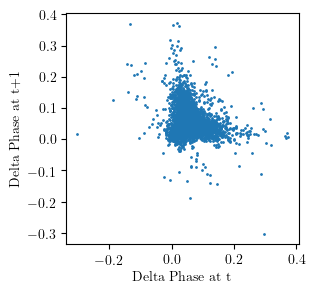

In [14]:
plt.figure(figsize = (3,3))
plt.scatter(oog.delta_phases[0:-1], oog.delta_phases[1:], s = 1)
plt.axis("equal")
plt.xlabel("Delta Phase at t")
plt.ylabel("Delta Phase at t+1")
plt.show()

In [5]:
i_prev = 0
beat_indices = []
for i in range(1, oog.phases.shape[0]):
    if (oog.phases[i] - oog.phases[i - 1]) < -np.pi:
        if abs(i_prev - i) > 5:
            beat_indices.append(i)
            i_prev = i

gradients = []
from scipy.optimize import curve_fit
for i in range(len(beat_indices) - 2):
    xs = range(beat_indices[i], beat_indices[i+2])
    ys = oog.unwrapped_phases[beat_indices[i]:beat_indices[i+2]]
    popt, popc = curve_fit(lambda x, a, b: a * x + b, xs, ys)
    gradients.append(popt[0])

gradients = np.array(OG.radsperframe_to_bps(np.array(gradients),80))


In [19]:
# Gets the noise spectrum by looking at the standard deviation of the change in delta phases over some time period.
def get_noise_spectrum(delta_phases, averaging_window):
    time_windows = range(1, (delta_phases.shape[0] - averaging_window) // 2, 1)
    avg_delta_phases_std = []
    for time_window in tqdm(time_windows):
        avg_delta_phases = []
        for i in np.arange(delta_phases.shape[0] - time_window - averaging_window):
            average_delta_phase_init = np.mean(delta_phases[i:i + averaging_window])
            average_delta_phase_final = np.mean(delta_phases[i + time_window:i + time_window + averaging_window])

            est_avg_delta_phases = average_delta_phase_init - average_delta_phase_final

            avg_delta_phases.append(est_avg_delta_phases)

        avg_delta_phases_std.append(np.std(avg_delta_phases))

    return time_windows, avg_delta_phases_std

In [20]:
dp_noise_spectrum = get_noise_spectrum(oog.delta_phases[0:5000], oog.sequence_manager.reference_sequence.shape[0])
gr_noise_spectrum = get_noise_spectrum(gradients, 3)

100%|██████████| 26/26 [00:00<00:00, 1582.21it/s]


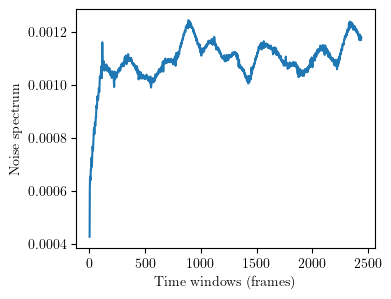

In [21]:
plt.figure()
plt.plot(*dp_noise_spectrum)
plt.xlabel("Time windows (frames)")
plt.ylabel("Noise spectrum")
plt.tight_layout()
plt.savefig("dp_noise_spectrum_prop.pgf")
plt.show()

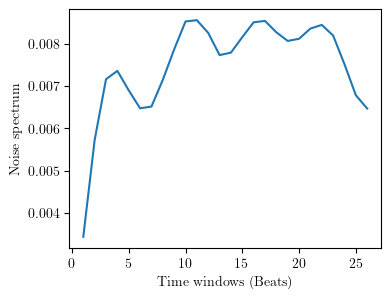

In [22]:
plt.figure()
plt.plot(*gr_noise_spectrum)
plt.xlabel("Time windows (Beats)")
plt.ylabel("Noise spectrum")
plt.tight_layout()
plt.savefig("gr_noise_spectrum_prop.pgf")
plt.show()